# Evomo Power Smart Detection Data Preprocessing
Bangkit Company Capstone Project [C242-PS01]

## Team Members
- M011B4KY1007 - Darren Christian Liharja
- C002B4KY2028 - Ivanoel Rhema Christama Adhiprama
- C002B4KY3771 - Reyhan Ghifari Tanjung
- A001B4KY2884 - Muhammad Haris Sabil Al Karim
- A318B4KX1511 - Fina Febrianti

## Problem Statements
Excessive energy consumption due to inefficient usage leads to increased costs and negative impacts on the environment Currently, energy inefficiencies and unusual usage patterns often go undetected, resulting in wasted resources. This project aims to develop an application that can monitor and detect energy usage patterns, provide real-time energy consumption information, and identify anomalies in energy usage. The application will also send notifications when anomalies occur, helping facility managers reduce energy waste and improve efficiency.

## Machine Learning Path Solution
Develop an anomaly detection model to identify spikes in energy consumption, enabling building managers to detect and address potential issues effectively.

## Data Source
Data are provided by Evomo. Data provided by Evomo are
- Energy Usage on certain areas

## Data Exploration and Cleaning

### Importing Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Extracting Data from Excel
The provided data are in the form of xlsx

In [2]:
df = pd.read_excel('data/Historical Data.xlsx', skiprows=1)
df

,Time,Data
0,26 Oct 2024 06:09:34,"{counter: 1,data: ""{""meter_type"":""mk10m"",""data..."
1,26 Oct 2024 06:07:45,"{data: ""{""meter_type"":""mk10m"",""data_type"":""ins..."
2,25 Oct 2024 13:59:39,"{counter: 48,data: ""{""meter_type"":""mk10m"",""dat..."
3,25 Oct 2024 13:39:30,"{counter: 46,data: ""{""meter_type"":""mk10m"",""dat..."
4,25 Oct 2024 13:29:34,"{counter: 45,data: ""{""meter_type"":""mk10m"",""dat..."
...,...,...
27407,01 Jan 2024 08:10:06,"{counter: 9,data: ""{""meter_type"":""mk10m"",""data..."
27408,01 Jan 2024 08:00:15,"{counter: 8,data: ""{""meter_type"":""mk10m"",""data..."
27409,01 Jan 2024 07:50:16,"{counter: 7,data: ""{""meter_type"":""mk10m"",""data..."
27410,01 Jan 2024 07:30:18,"{counter: 5,data: ""{""meter_type"":""mk10m"",""data..."


### Data Explanation
The dataset consists of two columns:
- Time: Contains timestamps which indicates when the data was collected.
- Data: Contains energy usage information for specific areas.

In [3]:
# A sample data from "data" column
sample = {
    "counter": 1,
    "data": {
        "meter_type": "mk10m",
        "data_type": "instant data",
        "reading_time": "2024-10-26 06:10:03",
        "meter_serial_number": "251400321",
        "active_energy_import": 49927072,
        "active_energy_export": 0,
        "reactive_energy_import": 82461,
        "reactive_energy_export": 27877274,
        "apparent_energy_import": 105524051,
        "apparent_energy_export": 0,
        "instantaneous_volatage_L1": 228.217,
        "instantaneous_volatage_L2": 228.282,
        "instantaneous_volatage_L3": 230.126,
        "instantaneous_current_L1": 0.387,
        "instantaneous_current_L2": 0.403,
        "instantaneous_current_L3": 0.41400000000000003,
        "instantaneous_net_frequency": 49.97,
        "instantaneous_power_factor": 0.08979999999999999,
        "create_date": "2024-10-26 06:10:06",
        "raw": "0f80000000000212167016c806671c254b0a09323531343030333231150000000002f9d3a015000000000000000015000000000001421d150000000001a95f9a1500000000064a2b531500000000000000000600037b790600037bba06000382ee06000001830600000193060000019e1213850500000382"
    },
    "devEui": "123494e68681e40c",
    "port": 11,
    "radio": {
        "modulation": {
        "bandwidth": 125000,
        "type": "LORA",
        "spreading": 8,
        "coderate": "4/5"
        },
        "hardware": {
        "status": 1,
        "chain": 0,
        "tmst": 0,
        "snr": 1,
        "rssi": -114,
        "channel": 0,
        "gps": {
            "lat": -6.237232685089111,
            "lng": 106.79916381835938,
            "alt": 12
        }
        },
        "freq": 921.8,
        "datarate": 4,
        "time": 1729897774.8805263
    },
    "type": "uplink"
}

Explanation of Electrical Concepts
- active_energy_import: The total active energy imported into the system, measured in kilowatt-hours (kWh). This represents the actual energy consumed.
- active_energy_export: The total active energy exported from the system, measured in kilowatt-hours (kWh). This occurs when excess energy is sent back to the grid.
- reactive_energy_import: The cumulative reactive energy imported into the system, measured in kilovolt-ampere reactive hours (kVarh). Reactive energy supports the magnetic and electric fields in devices like transformers and motors.
- reactive_energy_export: The cumulative reactive energy exported from the system, measured in kilovolt-ampere reactive hours (kVarh).
- apparent_energy_import: The total apparent energy imported into the system, measured in kilovolt-ampere hours (kVAh). Apparent energy is the vector sum of active and reactive energy.
- apparent_energy_export: The total apparent energy exported from the system, measured in kilovolt-ampere hours (kVAh).
- instantaneous_voltage_L1, L2, L3: The real-time voltage levels across each phase of the three-phase power system, e.g., 228.217 V for phase L1.
- instantaneous_current_L1, L2, L3: The real-time current levels flowing through each phase of the three-phase power system, e.g., 0.387 A for phase L1.
- instantaneous_net_frequency: The real-time frequency of the electrical network, measured in hertz (Hz), e.g., 49.97 Hz, which indicates the stability of the power supply.

The image below could also help understand the concept between active, reactive, and apparent energy

<img src="images/power.jpg" alt="Energy Type" style="width: 600px;"/>

### Advisor Suggestions
- Focus on "active_energy_import", which represents actual electricity consumption. Since this data is cumulative, calculate the energy usage by subtracting the value at time A from the value at time B.
- Use the data from February to August, as it offers the highest data quality.

### Extracting Important Data
The "data_type" feature is also included to account for potential differences in active_energy_import readings across different data types.

In [4]:
def extract_active_energy(data_str):
    match = re.search(r'"active_energy_import":\s*(\d+)', data_str)
    if match:
        return int(match.group(1))
    return None

def extract_data_type(data_str):
    match = re.search(r'"data_type":\s*"(.*?)"', data_str)
    if match:
        return match.group(1)
    return None

In [5]:
df['active energy import'] = df['Data'].apply(extract_active_energy)
df['data type'] = df['Data'].apply(extract_data_type)

Dropping the "Data" column to remove unnecessary features.

In [6]:
df = df.drop('Data', axis=1)

converting "Time" column to dataframe index and datetime format for easier preprocessing

In [7]:
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')

In [8]:
df.head()

,active energy import,data type
Time,,
2024-10-26 06:09:34,49927072,instant data
2024-10-26 06:07:45,49927064,instant data
2024-10-25 13:59:39,49873262,instant data
2024-10-25 13:39:30,49867253,instant data
2024-10-25 13:29:34,49864248,instant data


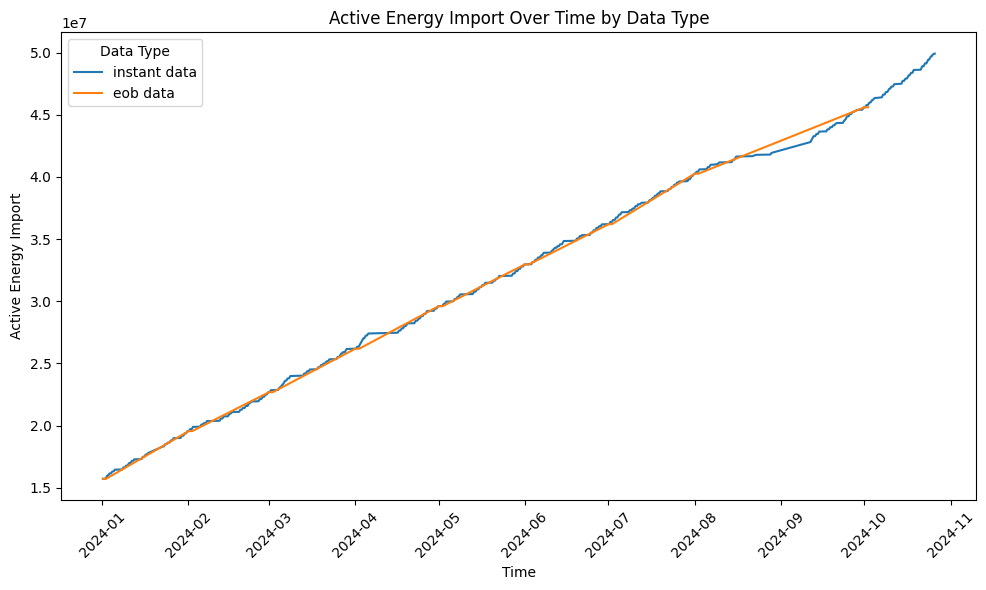

In [9]:
plt.figure(figsize=(10, 6))
for data_type in df['data type'].unique():
    subset = df[df['data type'] == data_type]
    plt.plot(subset.index, subset['active energy import'], label=data_type)

plt.title('Active Energy Import Over Time by Data Type')
plt.xlabel('Time')
plt.ylabel('Active Energy Import')
plt.legend(title='Data Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
eob_count = (df['data type'] == 'eob data').sum()
print(eob_count)

77


From the plot above, there are 2 data types
- instant data
- eob data
Since eob data accounts for a very small percentage of the data. I decided to drop the eob data type completely to remove variance in the data

### Removing Eob Data Type

In [11]:
df.drop(df[df['data type'] == 'eob data'].index, inplace=True)

## Creating New Data Frame
To simplify the modeling process, a new dataframe will be created containing the features that will help identify energy usage anomalies.

Changing the timestamps to a consistent hourly rate instead of per polling allows for resampling the dataframe and calculating the average of "active energy import" over each hour.

In [12]:
def hourly_mean(df):
    df_hourly = []
    for hour, group in df.resample('h'):
        mean_value = group['active energy import'].mean()
        df_hourly.append((hour, mean_value))
    
    return pd.DataFrame(df_hourly, columns=['timestamp', 'hourly average'])

In [13]:
df_hourly = hourly_mean(df)

Checking on nan values which indicates there is no data on specific hours

In [14]:
nan_count = df_hourly['hourly average'].isna().sum()
print(nan_count)

1220


In [15]:
df_hourly = df_hourly.dropna(subset=['hourly average'])

### Filtering Timestamps (February to August)
Following the suggestions from company advisor. Only data from February to August will be taken

In [18]:
def filter_february_to_august(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    filtered_df = df[(df['timestamp'].dt.month >= 2) & (df['timestamp'].dt.month <= 8)]
    
    return filtered_df

In [19]:
df_hourly = filter_february_to_august(df_hourly)

### Calculate Usage
To calculate the energy usage, we would need the difference between time A and time B

Points to consider
-  there are missing values in the timestamp which might result in unexpectedly large usage

To combat this problem the one of the solution is to use the formula 
usage = (active energy import[i] - active energy import[i-1])/difference in hour

In [20]:
def calculate_usage(df):
    df['usage'] = (df['hourly average'].diff() / (df['timestamp'].diff().dt.total_seconds() / 3600)) / 1000 # divided by 1000 to convert it to KwH
    df['usage'].iloc[0] = 0 

    return df

In [21]:
df_hourly = calculate_usage(df_hourly)

C:\Users\62813\AppData\Local\Temp\ipykernel_3816\3859636708.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['usage'].iloc[0] = 0
C:\Users\62813\AppData\Local\Temp\ipykernel_3816\3859636708.py:3: SettingWithCopyWarning: 
A value is try

### Adding Features
Set the timestamp as the index and add "hour" and "day of the week" features to enhance the dataset for modeling purposes. These new features can help capture temporal patterns in energy usage.

In [22]:
df_hourly.set_index('timestamp', inplace=True)
df_hourly['hour'] = df_hourly.index.hour
df_hourly['day_of_week'] = df_hourly.index.dayofweek

In [23]:
df_hourly.head

<bound method NDFrame.head of                      hourly average      usage  hour  day_of_week
timestamp                                                        
2024-02-01 00:00:00    1.955991e+07   0.000000     0            3
2024-02-01 01:00:00    1.956011e+07   0.199500     1            3
2024-02-01 02:00:00    1.956033e+07   0.220500     2            3
2024-02-01 03:00:00    1.956056e+07   0.225000     3            3
2024-02-01 04:00:00    1.956076e+07   0.204500     4            3
...                             ...        ...   ...          ...
2024-08-28 09:00:00    4.186957e+07  13.110667     9            2
2024-08-28 10:00:00    4.189131e+07  21.741000    10            2
2024-08-28 11:00:00    4.190912e+07  17.805583    11            2
2024-08-28 12:00:00    4.192575e+07  16.629350    12            2
2024-08-28 13:00:00    4.194027e+07  14.523650    13            2

[4477 rows x 4 columns]>

In [24]:
df_hourly.to_csv('data/conv_data.csv')